In [2]:
from __future__ import division

import numpy as np
import glob, os, json
import matplotlib.pyplot as plt
import scipy.linalg as sl
from astropy import units as u
from astropy.coordinates import SkyCoord

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import targeted_functions as fns

from io import StringIO


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
datadir='/Users/caitlinawitt/Desktop/nano11'

Do not have mpi4py package.


In [3]:
p11 = np.loadtxt(datadir+'/psrlist_Tg3yr.txt', dtype='S42').astype('str')
print(p11)

['J1713+0747' 'J1909-3744' 'J2317+1439' 'J1600-3053' 'J1640+2224'
 'J1614-2230' 'J1918-0642' 'J2043+1711' 'J0030+0451' 'J1744-1134'
 'J1741+1351' 'J0613-0200' 'B1855+09' 'J2010-1323' 'J1455-3330' 'B1937+21'
 'J0645+5158' 'J1012+5307' 'J2145-0750' 'J1024-0719' 'J1738+0333'
 'J1910+1256' 'J1923+2515' 'J1853+1303' 'J1944+0907' 'J2017+0603'
 'J1643-1224' 'J0340+4130' 'B1953+29' 'J2214+3000' 'J1903+0327'
 'J1747-4036' 'J2302+4442' 'J0023+0923']


In [4]:
c_3c66b = SkyCoord('02h23m11.4112s', '+42d59m31.384s', frame='icrs')
c_rod = SkyCoord('10h18m33.64s', '+36d13m26.62s', frame='icrs')
##BS sample for proposal
c_1511_04 = SkyCoord('15h11m0s', '+04d17m0s', frame='icrs')
c_1655 = SkyCoord('16h55m0s', '+26d39m0s', frame='icrs')
c_1445 = SkyCoord('14h45m0s', '+51d34m0s', frame='icrs')
c_1511_23 = SkyCoord('15h11m0s', '+23d09m0s', frame='icrs')
c_0206 = SkyCoord('02h06m0s', '-00d17m0s', frame='icrs')

names = ['1511+0417','1655+2639', '1445+5134', '1511+2309', '0206-0017']

coord = []
c_1713 = []
c_0613 = []
for i in range(len(p11)):
    if 'J' in p11[i]:
        if '+' in p11[i]:
            a = p11[i].split('J')[1]
            b = a.split('+')[0]
            c = a.split('+')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('+'+c[0:2]+'d'+c[2:4]+'m00s')
            if '1713' in p11[i]:
                c_1713.append(SkyCoord(ra, dec, frame='icrs'))
            else:
                coord.append(SkyCoord(ra, dec, frame='icrs'))

        else:
            a = p11[i].split('J')[1]
            b = a.split('-')[0]
            c = a.split('-')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('-'+c[0:2]+'d'+c[2:4]+'m00s')
            if '0613' in p11[i]:
                c_0613.append(SkyCoord(ra, dec, frame='icrs'))
            else:
                coord.append(SkyCoord(ra, dec, frame='icrs'))
    else:
        if '+' in p11[i]:
            a = p11[i].split('B')[1]
            b = a.split('+')[0]
            c = a.split('+')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('+'+c[0:2]+'d'+'00m00s')
            coord.append(SkyCoord(ra, dec, frame='fk4'))
        else:
            a = p11[i].split('B')[1]
            b = a.split('-')[0]
            c = a.split('-')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('-'+c[0:2]+'d'+'00m00s')
            coord.append(SkyCoord(ra, dec, frame='fk4'))

In [5]:
c_0613

[<SkyCoord (ICRS): (ra, dec) in deg
     (93.25, -2.)>]

In [6]:
ra=[]
dec=[]
ra_0613 = [c_0613[0].ra.deg]
ra_1713 = [c_1713[0].ra.deg]
for i in range(len(coord)):
    ra.append(coord[i].ra.deg)
    dec.append(coord[i].dec.rad)
print(ra)

[287.24999999999994, 349.25, 239.99999999999997, 250.0, 243.49999999999997, 289.5, 310.74999999999994, 7.499999999999999, 266.0, 265.25, 283.75, 302.5, 223.74999999999997, 294.25, 101.24999999999999, 152.99999999999997, 326.24999999999994, 156.0, 264.49999999999994, 287.5, 290.74999999999994, 283.24999999999994, 296.0, 304.25, 250.74999999999994, 54.99999999999999, 298.24999999999994, 333.5, 285.75, 266.75, 345.5, 5.75]


In [7]:
def convert_RA(RA,org=0):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    for i in range(len(tick_labels)):
        tick_labels[i]=float(tick_labels[i])
    
    return np.radians(x), tick_labels
    


In [8]:
print(ra)

[287.24999999999994, 349.25, 239.99999999999997, 250.0, 243.49999999999997, 289.5, 310.74999999999994, 7.499999999999999, 266.0, 265.25, 283.75, 302.5, 223.74999999999997, 294.25, 101.24999999999999, 152.99999999999997, 326.24999999999994, 156.0, 264.49999999999994, 287.5, 290.74999999999994, 283.24999999999994, 296.0, 304.25, 250.74999999999994, 54.99999999999999, 298.24999999999994, 333.5, 285.75, 266.75, 345.5, 5.75]


In [9]:
RA, tick_labels = convert_RA(np.array(ra), org=180)
RA_1713, tick_labels_1713 = convert_RA(np.array(ra_1713), org=180)
RA_0613, tick_labels_0613 = convert_RA(np.array(ra_0613), org=180)

tick_labels_h = (tick_labels*24/360)
print(tick_labels_h)
tick_labels_n=[]
for i in range(len(tick_labels_h)):
    tick_labels_n.append(str(int(tick_labels_h[i]))+'h')
print(tick_labels_n)




[22. 20. 18. 16. 14. 12. 10.  8.  6.  4.  2.]
['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h']


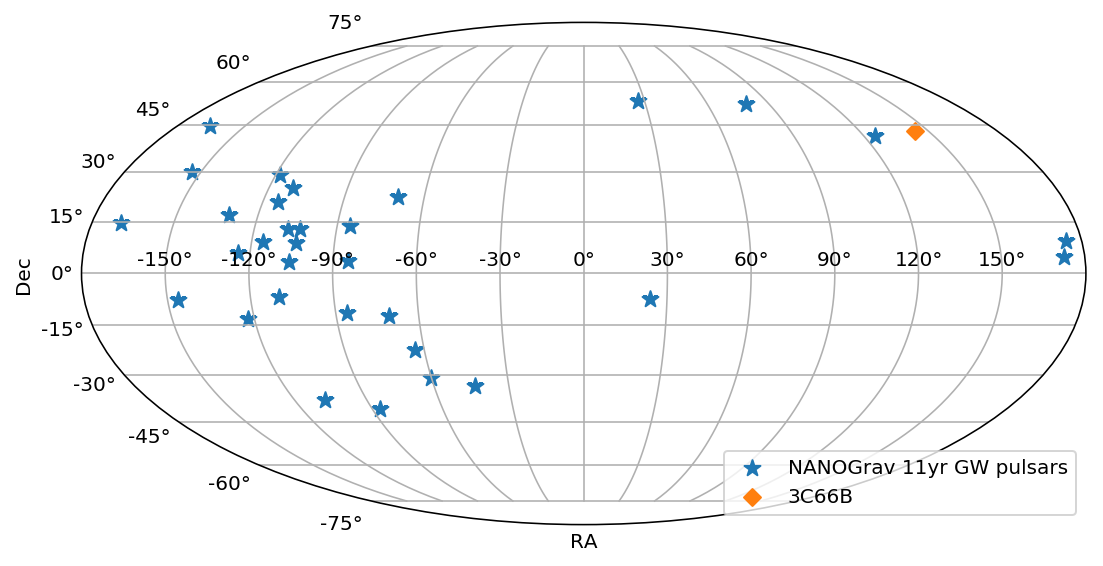

In [10]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True)
ax.scatter(RA,np.array(dec), color='C0', marker='*', label='NANOGrav 11yr GW pulsars', s = 70)  # convert degrees to radians
ax.scatter(convert_RA(np.array([c_3c66b.ra.deg]), org=180)[0], np.array([c_3c66b.dec.rad]), color='C1', marker='D', label='3C66B')
#ax.scatter(convert_RA(np.array([c_rod.ra.deg]), org=180)[0], np.array([c_rod.dec.rad]), color='C3', marker='o')
#ax.scatter(convert_RA(np.array([c_1511_04.ra.deg]), org=180)[0], np.array([c_1511_04.dec.rad]), color='C1', marker='D', label=names[0])
#ax.scatter(convert_RA(np.array([c_1655.ra.deg]), org=180)[0], np.array([c_1655.dec.rad]), color='C2', marker='D', label=names[1])
#ax.scatter(convert_RA(np.array([c_1445.ra.deg]), org=180)[0], np.array([c_1445.dec.rad]), color='C3', marker='D', label=names[2])
#ax.scatter(convert_RA(np.array([c_1511_23.ra.deg]), org=180)[0], np.array([c_1511_23.dec.rad]), color='C4', marker='D', label=names[3])
#ax.scatter(convert_RA(np.array([c_0206.ra.deg]), org=180)[0], np.array([c_0206.dec.rad]), color='C5', marker='D', label=names[4])
#names = ['1511+0417','1655+2639', '1445+5134', '1511+2309', '0206-0017']

#tick_labels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h']

#ax.set_xticklabels(tick_labels_n)     # we add the scale on the x axis
#ax.set_title(title)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.legend(loc='lower right')
#plt.savefig('bs237_skymap.pdf')

In [11]:
c = c_3c66b
gw_theta = (np.pi)/2-c.dec.rad
gw_phi = c.ra.rad
theta = np.linspace(0.01,np.pi,50)
phi = np.linspace(0.01,2*np.pi,100)
data = np.zeros((len(theta), len(phi)))
for i in range(len(theta)):
    for j in range(len(phi)):
        dat = fns.create_gw_antenna_pattern(theta[i],phi[j],gw_theta,gw_phi)
        data[i,j] = dat[0]**2 + dat[1]**2

In [12]:
ra = phi*u.rad
Dec = ((np.pi/2)-theta)*u.rad
ra_deg=ra.to(u.deg);
Ra,DEC = np.meshgrid(convert_RA(np.array([ra_deg]), org=180)[0],Dec)


In [13]:
from matplotlib import patheffects
from matplotlib import text


In [14]:
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size':14})#,'weight':'bold'})
plt.rc('xtick',**{'labelsize':16})
plt.rc('ytick',**{'labelsize':16})
plt.rc('axes',**{'labelsize':18,'titlesize':18})


/anaconda3/envs/enterprise/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


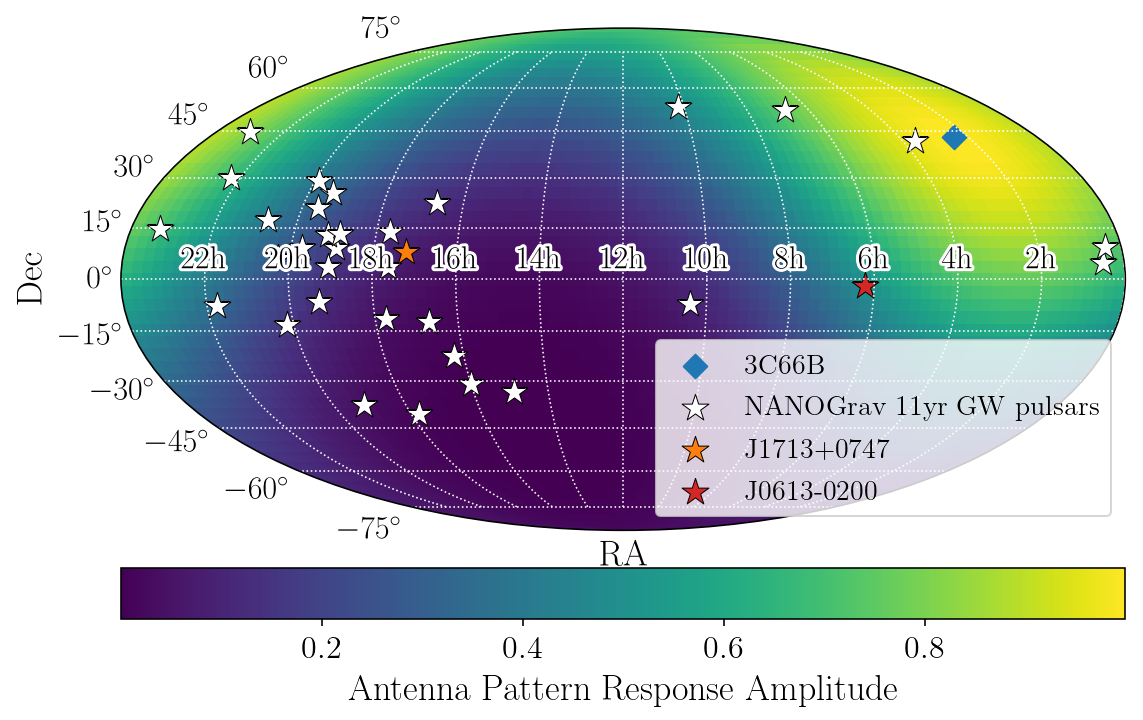

In [15]:



fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True)
ax.grid()
im = ax.pcolormesh(Ra,DEC,data)
fig.colorbar(im, ax=ax, orientation = 'horizontal', pad = 0.05, label = 'Antenna Pattern Response Amplitude')
plt.grid(linestyle='dotted', color='w', zorder=8)
ax.scatter(convert_RA(np.array([c_3c66b.ra.deg]), org=180)[0], np.array([c_3c66b.dec.rad]), color='C0', marker='D', label='3C66B', s=70)

ax.scatter(RA,np.array(dec), color='w', marker='*', linewidths=0.5, edgecolors='k', label='NANOGrav 11yr GW pulsars', s = 200)  # convert degrees to radians
ax.scatter(RA_1713,c_1713[0].dec.rad, color='C1', marker='*', linewidths=0.5, edgecolors='k', label='J1713+0747', s = 200)  # convert degrees to radians
ax.scatter(RA_0613,c_0613[0].dec.rad, color='C3', marker='*', linewidths=0.5, edgecolors='k', label='J0613-0200', s = 200)  # convert degrees to radians

#tick_labels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h']

y_ticks = ['$-75^\circ$', '$-60^\circ$', '$-45^\circ$','$-30^\circ$','$-15^\circ$','$0^\circ$',
           '$15^\circ$','$30^\circ$','$45^\circ$','$60^\circ$','$75^\circ$',]

ax.set_xticklabels(tick_labels_n, color = 'k')#, **csfont)




effects = [patheffects.withStroke(linewidth=3, foreground='w')]
for artist in ax.findobj(text.Text):
    artist.set_path_effects(effects)
    
ax.set_xlabel('RA')#, **csfont)
ax.set_ylabel('Dec')#,**csfont)

ax.set_yticklabels(y_ticks)#, **csfont)     # we add the scale on the x axis

    
plt.legend(loc='lower right')

plt.savefig('/Users/caitlinawitt/Documents/3c66b/plots/antenna_skymap.pdf', bbox_inches='tight')

In [18]:
type(tick_labels_n[0])

str

In [149]:
ax.artists

[]